In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import itertools
from functools import reduce

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from scipy import stats
import statsmodels.api as sm
from itertools import product

from sklearn.metrics import f1_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve

# Price Prediction of Ethereum's Cryptocurrency Ether (ETH)

## Using Machine Learning Models to Predict Price Movements

![Alt text](https://i.imgur.com/enQx3jD.jpg)

## Problem Introduction

My goal is to build several different ML models and to check which one(s) will perform best in predicting the price of Ethereum's cryptocurrency ETH. To do that I will use publicly available information on ETH's historical price, as well as data on Ethereum blockchain-related indicators such as number of daily transaction, daily contracts or addresses created. 

I will set up 3 different datasets which will be as follows:
- Dataset I: a historical price dataset where the daily 'Close' ETH price is taken as the target and details on the 'Open', 'High', 'Low' Prices, ETH's trade Volume and ETH's market capitalization comprise the training set. 
- Dataset II: a time-series dataset where additional time sequence variables are extracted.
- Dataset III: a dataset of 10 uncorrelated blockchain-related indicators to check if they can be used to predict the ETH Price. 

Each dataset allows for the use of different machine learning models. Some will give spectacular results, other - nearly mediocre ones. 

I have taken ideas and inspiration from several Kaggle notebooks as well as from research papers on [Ethereum price forecasting](https://arno.uvt.nl/show.cgi?fid=157717) and on using [Time Series Analysis to predict stock prices](https://arxiv.org/ftp/arxiv/papers/2004/2004.11697.pdf).

## Dataset I

In [3]:
eth = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/ethereum_2015-08-07_2022-11-20.csv")
eth

,Date,Open,High,Low,Close,Volume,Market Cap
0,Nov-18-2022,1212.813971,1227.419300,1200.788200,1218.902299,9.537880e+09,1.480340e+11
1,Nov-17-2022,1200.797267,1227.657224,1200.797267,1213.309305,1.570107e+10,1.485864e+11
2,Nov-16-2022,1217.596530,1226.466113,1188.083400,1200.163955,1.915299e+10,1.475286e+11
3,Nov-15-2022,1253.747300,1265.637300,1194.687196,1217.306892,2.033123e+10,1.506058e+11
4,Nov-14-2022,1242.079348,1285.393600,1238.715646,1252.796100,2.368056e+10,1.543662e+11
...,...,...,...,...,...,...,...
2656,Aug-11-2015,1.067860,1.289940,0.883608,1.237670,1.971841e+06,6.682610e+07
2657,Aug-10-2015,0.708448,1.131410,0.663235,1.057670,6.406322e+05,4.768204e+07
2658,Aug-09-2015,0.701897,0.729854,0.636546,0.707703,4.577479e+05,4.182758e+07
2659,Aug-08-2015,0.753325,0.879810,0.629191,0.729347,6.998264e+05,4.156260e+07


### 1.1. Exploratory Data Analysis (EDA)

In [4]:
#Converting the Date column into easy-to-use format
eth['Date'] = pd.to_datetime(eth['Date'])

C:\Users\35989\AppData\Local\Temp\ipykernel_18772\4258960067.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(eth.corr() > 0.9, annot=True, cbar=False, cmap='tab20b_r')


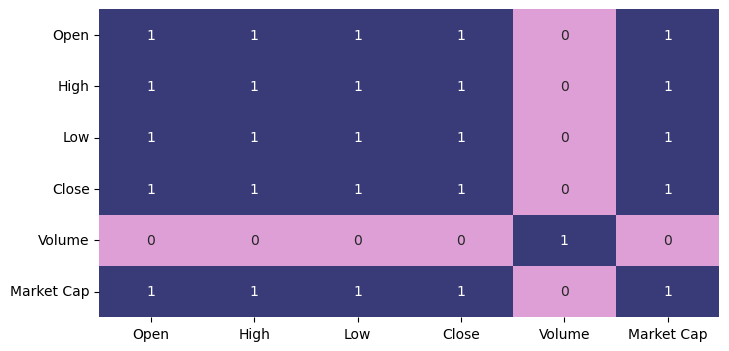

In [5]:
#Checking for correlation between features
plt.figure(figsize=(8, 4))
sb.heatmap(eth.corr() > 0.9, annot=True, cbar=False, cmap='tab20b_r')
plt.show()

#As expected, most of the dataset's features are strongly correlated, which is a problem for some models. 

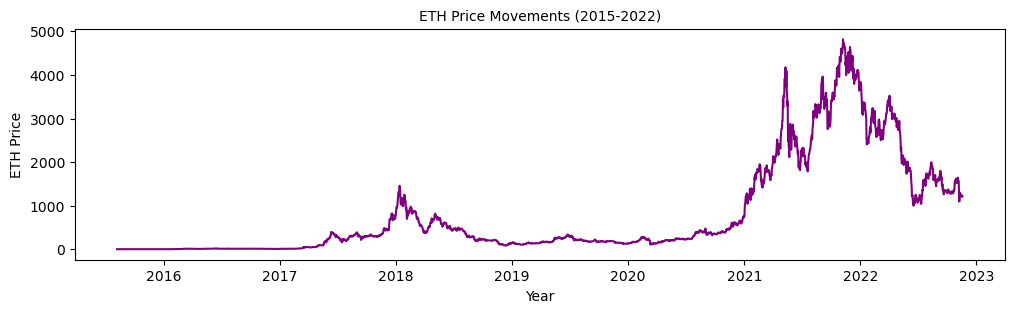

In [6]:
#ETH Price Movements over the whole observed period
plt.figure(figsize=(12,3))
plt.plot(eth['Date'], eth['Close'], color='purple')
plt.xlabel('Year', fontsize=10)
plt.ylabel('ETH Price', fontsize=10)
plt.title('ETH Price Movements (2015-2022)', fontsize=10)
plt.show()

#The ETH price has marked a strong peak in 2018 before reaching its all-time-high level in late-2021.
#It has been on the decline over most of 2022. 

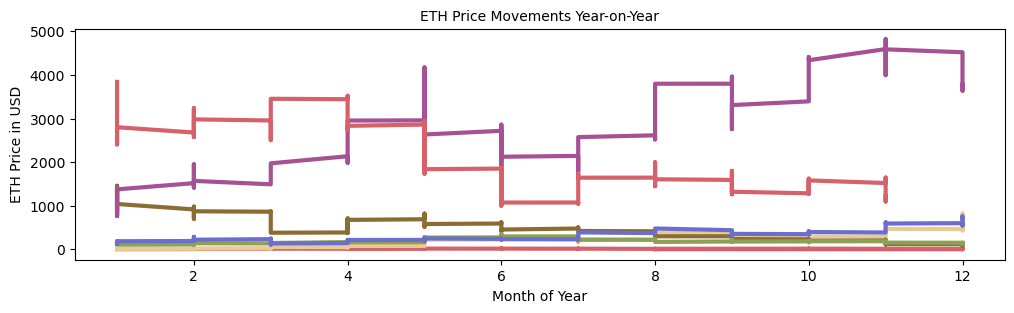

In [7]:
#ETH Price Movements over the whole observed period - checking for seasonality
plt.figure(figsize=(12,3))
color = itertools.cycle(sb.color_palette('tab20b_r'))
for year in range(2015, 2023):
    current_year = eth[eth['Date'].dt.year == year]
    plt.plot(current_year['Date'].dt.month, current_year['Close'], color=next(color), linewidth=3)
    
plt.xlabel('Month of Year', fontsize=10)
plt.ylabel('ETH Price in USD', fontsize=10)
plt.title('ETH Price Movements Year-on-Year', fontsize=10)
plt.show()

#There seems to be no seasonal behaviour of ETH price movements. 

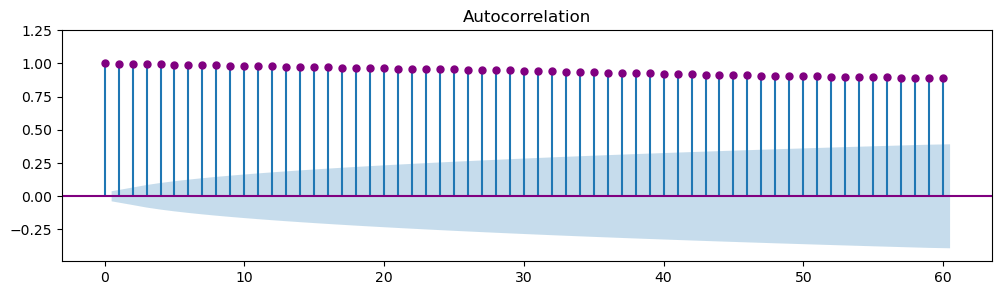

In [8]:
#Checking for Autocorrelation of ETH 'Close' Price Over a 5-Year Period
plt.figure(figsize=(12,3))
plt.subplot()
plot_acf(eth['Close'], ax=plt.gca(), lags=60, color='purple', auto_ylims=True)
plt.show()

#ETH Price is strongly autocorrelated month-on-month.

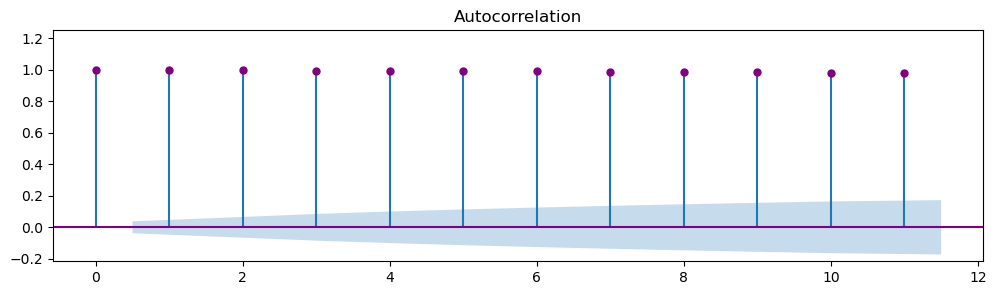

In [9]:
#Checking for Autocorrelation of ETH 'Close' Price Year-on-Year
plt.figure(figsize=(12,3))
plt.subplot()
plot_acf(eth['Close'], ax=plt.gca(), lags=range(12), color='purple', auto_ylims=True)
plt.show()

#The yearly autocorrelation is absolute.

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


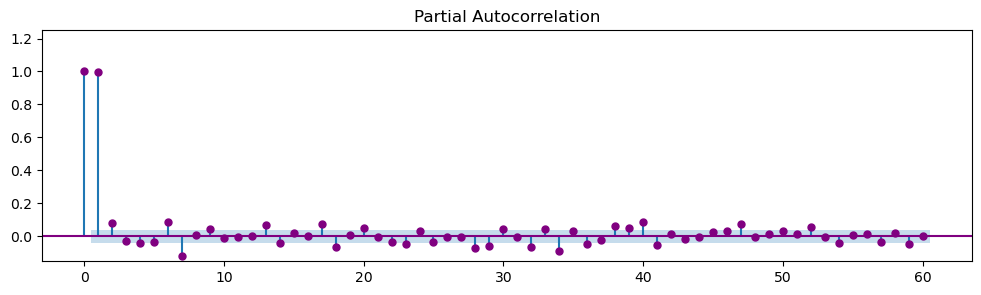

In [10]:
#Checking for Partial Autocorrelation of ETH 'Close' Price Over a 5-Year Period
plt.figure(figsize=(12,3))
plt.subplot()
plot_pacf(eth['Close'], ax=plt.gca(), lags=60, color='purple', auto_ylims=True)
plt.show()

#The monthly partial autocorrelation is nearly insignificant. 

C:\Users\35989\AppData\Local\Temp\ipykernel_18772\741612409.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  eth_month = eth_df.resample('M').mean()


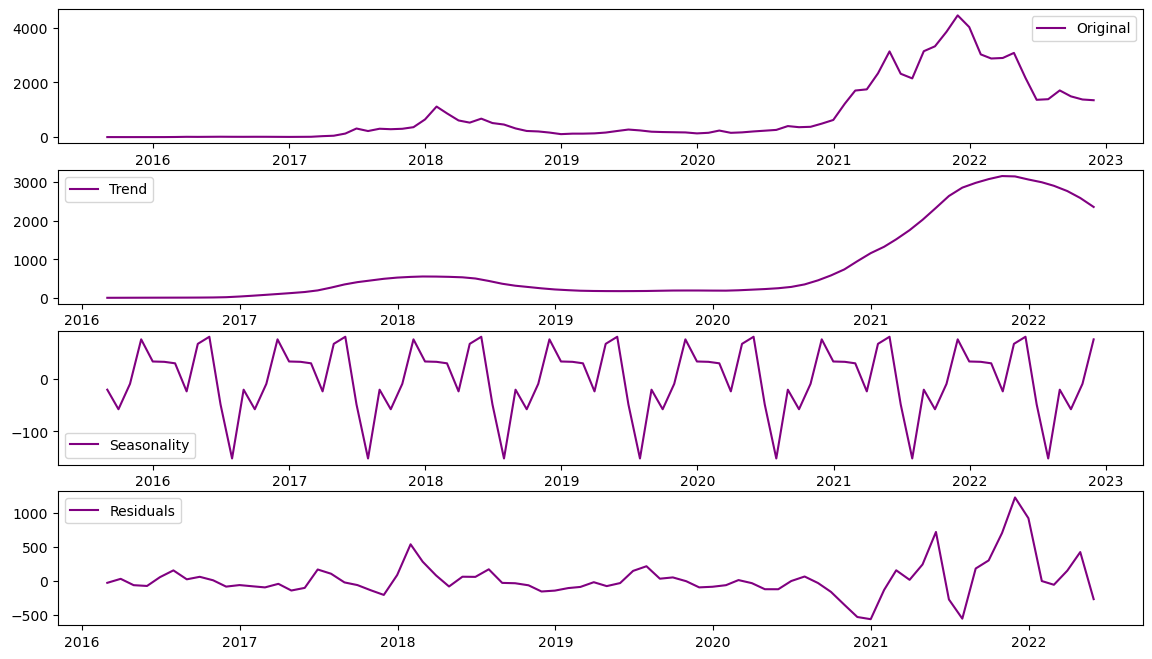

In [11]:
#Seasonal Decomposing
eth_df = eth.set_index(eth['Date'])
eth_month = eth_df.resample('M').mean()

decomposition = seasonal_decompose(eth_month['Close'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14,8))
plt.subplot(411)
plt.plot(eth_month['Close'], label='Original', color='purple')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='purple')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='purple')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='purple')
plt.legend(loc='best')
plt.show()

#The seasonal decomposing showed that there is a distinct seasonality after all. 
#It aslo showed that the residuals have been at their peak over 2021 and 2022. 
#The volatility of the crypto market, and in particular ETH, is notoriously high.
#However, seems like over this 2-year period the fluctuations have been much larger than before.
#Moreover, the general trend has been upwards up until 2021, and has been falling down in 2022.

### 1.2. Splitting the Data & Normalizatiom

In [12]:
#Setting the Date column as index
eth.set_index('Date', inplace=True)

In [13]:
#Splitting the dataset into Attributes and Target
eth_attributes = eth.drop(columns='Close')
eth_target = eth['Close']

In [14]:
#Normalization
def normalize(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled, columns=df.columns, index=df.index)
    return scaled_df

In [15]:
eth_attributes = normalize(eth_attributes)

In [16]:
#Splitting the dataset into Training and Testing Sets
eth_attributes_train, eth_attributes_test, eth_labels_train, eth_labels_test = train_test_split(eth_attributes, eth_target, random_state = 0, train_size = 0.7)

In [17]:
eth_attributes_train.shape, eth_attributes_test.shape, eth_labels_train.shape, eth_labels_test.shape

((1862, 5), (799, 5), (1862,), (799,))

In [18]:
#Cross-Validation
k_fold = StratifiedKFold(n_splits = 5, shuffle = False)

## Model I: Ridge Regression

In [19]:
for this_alpha in [0.01, 0.1, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(eth_attributes_train, eth_labels_train)
    r2_train = linridge.score(eth_attributes_train, eth_labels_train)
    r2_test = linridge.score(eth_attributes_test, eth_labels_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Alpha = 0.01
num abs(coeff) > 1.0: 3, r-squared training: 1.00, r-squared test: 1.00

Alpha = 0.10
num abs(coeff) > 1.0: 5, r-squared training: 1.00, r-squared test: 1.00

Alpha = 1.00
num abs(coeff) > 1.0: 5, r-squared training: 1.00, r-squared test: 1.00

Alpha = 10.00
num abs(coeff) > 1.0: 5, r-squared training: 1.00, r-squared test: 1.00

Alpha = 20.00
num abs(coeff) > 1.0: 5, r-squared training: 1.00, r-squared test: 1.00

Alpha = 50.00
num abs(coeff) > 1.0: 5, r-squared training: 1.00, r-squared test: 1.00

Alpha = 100.00
num abs(coeff) > 1.0: 5, r-squared training: 1.00, r-squared test: 1.00

Alpha = 1000.00
num abs(coeff) > 1.0: 5, r-squared training: 0.98, r-squared test: 0.98



In [20]:
model = Ridge(alpha=0.01)

In [21]:
model.fit(eth_attributes_train, eth_labels_train)

Ridge(alpha=0.01)

In [22]:
model.score(eth_attributes_train, eth_labels_train)

0.9994247841498839

In [23]:
model.score(eth_attributes_test, eth_labels_test)

0.9993616510788667

In [24]:
predictions = model.predict(eth_attributes_test)

Text(0, 0.5, 'Normalized Error')

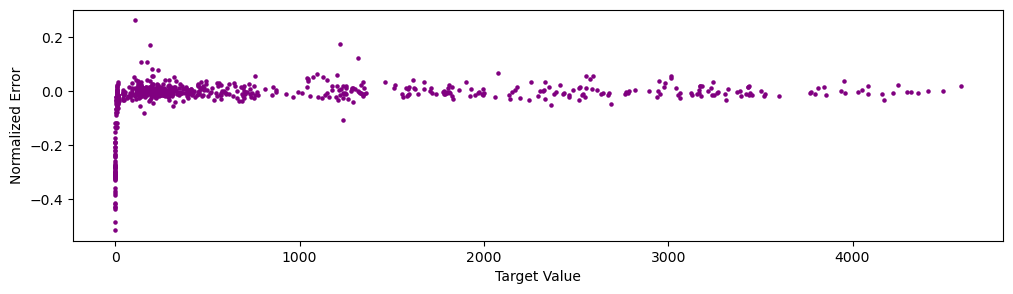

In [25]:
#Normalized Error
plt.figure(figsize=(12,3))
plt.scatter(eth_labels_test, (predictions - eth_labels_test) / eth_labels_test, color='purple', s=5)
plt.xlabel('Target Value')
plt.ylabel('Normalized Error') 

Text(0.5, 1.0, 'Prediction Vs. Reality - Ridge Regression')

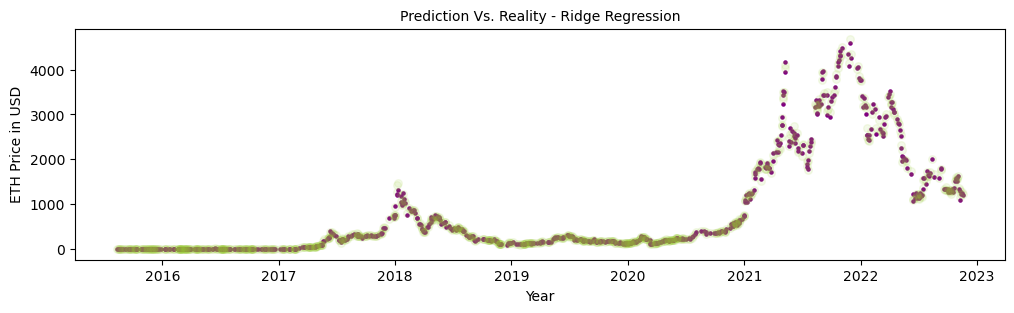

In [26]:
plt.figure(figsize=(12,3))
plt.scatter(eth_labels_test.index, eth_labels_test, color='purple', label='Test Predictions', s=5)
plt.scatter(eth_attributes_test.index, predictions, color='yellowgreen', alpha=0.1, label='Test Predictions', s=30)
plt.xlabel('Year', fontsize=10)
plt.ylabel('ETH Price in USD', fontsize=10)
plt.title("Prediction Vs. Reality - Ridge Regression", fontsize=10)

## Model II: Logistic Regression

In [27]:
BUY = 1
SELL = 0
eth['Buy/Sell'] = np.where(eth['Close'].shift(1) > eth['Close'], 
                                BUY,
                                SELL)

In [28]:
eth_attributes2 = eth.drop(columns='Buy/Sell')
eth_labels2 = eth['Buy/Sell']

In [29]:
#Splitting the dataset into Training and Testing Sets
eth_attributes_train2, eth_attributes_test2, eth_labels_train2, eth_labels_test2 = train_test_split(eth_attributes2, eth_labels2, random_state = 0, train_size = 0.7)

In [30]:
grid_search = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = {
        "C": [0.01, 0.1, 1, 10, 100],
        "fit_intercept" : [True, False], 
        "max_iter" : [10, 100, 200, 250]
    },
    scoring = "f1", 
    cv = k_fold
)
grid_search.fit(eth_attributes_train2, eth_labels_train2)
logreg_classifier = grid_search.best_estimator_

print("Logistic Regression; best estimators:", grid_search.best_estimator_)
print("Logistic Regression; best score:", grid_search.best_score_)

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Logistic Regression; best estimators: LogisticRegression(C=0.01, max_iter=10)
Logistic Regression; best score: 0.6039281356572015


In [31]:
eth_attributes_predicted_logreg = logreg_classifier.predict(eth_attributes_test2)
logreg_classifier_score = f1_score(eth_labels_test2, eth_attributes_predicted_logreg)
print("Logistic Regression Score:", logreg_classifier_score)

Logistic Regression Score: 0.6901639344262295


## Dataset II - Price and Time Series Features

In [32]:
eth3 = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/ethereum_2015-08-07_2022-11-20.csv")
eth3['Date'] = pd.to_datetime(eth3['Date'], format="%b-%d-%Y")

In [33]:
#To predict a day price, I'll need price sampling done at least twice a day, so I'll get the 'Open' and 'Close' prices
eth3 = eth3.drop(columns=['High', 'Low', 'Volume', 'Market Cap'])

In [34]:
#Extraxting new features 
eth3['Year'] = eth3['Date'].dt.year
eth3['Month'] = eth3['Date'].dt.month
eth3['Day'] = eth3['Date'].dt.day
eth3 = eth3.drop(columns='Date')
eth3

,Open,Close,Year,Month,Day
0,1212.813971,1218.902299,2022,11,18
1,1200.797267,1213.309305,2022,11,17
2,1217.596530,1200.163955,2022,11,16
3,1253.747300,1217.306892,2022,11,15
4,1242.079348,1252.796100,2022,11,14
...,...,...,...,...,...
2656,1.067860,1.237670,2015,8,11
2657,0.708448,1.057670,2015,8,10
2658,0.701897,0.707703,2015,8,9
2659,0.753325,0.729347,2015,8,8


In [35]:
for shift in range(1, 13):
    eth3[f"lag_{shift}"] = eth3['Close'].shift(shift)
    
for diff in [1, 2, 5, 10]:
    eth3[f"d_{diff}"] = eth3['Close'].diff(diff)

In [36]:
eth3.dropna(inplace=True)

In [37]:
target3 = eth3['Close']
attributes3 = eth3.drop(columns='Close')

In [38]:
attributes3_train, attributes3_test, labels3_train, labels3_test = train_test_split(attributes3, target3, random_state = 0)

In [39]:
attributes3_train.shape, attributes3_test.shape, labels3_train.shape, labels3_test.shape

((1986, 20), (663, 20), (1986,), (663,))

## Model I: Lasso Regression

In [40]:
scaler = MinMaxScaler()

In [41]:
pca = PCA()

In [42]:
lasso = Lasso()

In [43]:
pipe = Pipeline(steps = [("scaler", scaler), ("pca", pca), ("lasso_regression", lasso)])

In [44]:
n_components = list(range(1, attributes3.shape[1]+1, 1))
normalize = [True, False]
selection = ["cyclic", "random"]
parameters = dict(pca__n_components=n_components, lasso_regression__normalize=normalize, lasso_regression__selection=selection)
model1 = GridSearchCV(pipe, parameters)
model1.fit(attributes3_train, labels3_train)
predictions_lasso_r_test = model1.best_estimator_.predict(attributes3_test)
predictions_lasso_r_train = model1.best_estimator_.predict(attributes3_train)

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. 

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The defau

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' wa

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' wa

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' wa

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' wa

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' wa

C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\35989\miniconda3\envs\tfdml_plugin\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' wa

In [45]:
model1.score(attributes3_test, labels3_test)

0.9994350004599801

In [46]:
model1.score(attributes3_train, labels3_train)

0.999471616811775

## Model II: Random Forest

In [47]:
forest = RandomForestRegressor()

In [48]:
pipe2 = Pipeline(steps = [("scaler", scaler), ("reduce_dim", pca), ('regressor', forest)])

In [49]:
param_grid = dict(reduce_dim=['passthrough', PCA(5), PCA(10)],
                  regressor__n_estimators = [50, 100, 200],
                  regressor__max_depth = [10, 20, 50])
model2 = GridSearchCV(pipe2, param_grid=param_grid)
model2.fit(attributes3_train, labels3_train)
predictions_forest_test = model2.best_estimator_.predict(attributes3_test)
predictions_forest_train = model2.best_estimator_.predict(attributes3_train)

In [50]:
model2.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()), ('reduce_dim', 'passthrough'),
                ('regressor',
                 RandomForestRegressor(max_depth=50, n_estimators=50))])

In [51]:
model2.score(attributes3_test, labels3_test)

0.9983363526071002

In [52]:
model2.score(attributes3_train, labels3_train)

0.9997565986630444

## Dataset III - Ethereum Blockchain-Related Features

The source of the information below is [etherscan.io](https://etherscan.io/charts) which is one of the most popular public blockchain explorers for the Ethereum network.

I want to check whether different indicators of the functioning of the Ethereum blockchain can be used to predict ETH price. I made sure that my dataset's features will not be linearly correlated with each other.

The indicators I will use as training data are as follows:
- Average Daily Hash Rate
- Number of Daily Transactions
- Average Daily Transaction Fees in USD
- Daily Gas Usage 
- Number of Blocks Produced Daily
- Average Time Between Each New Block in Seconds
- Units of ETH Created Daily (New Supply)
- Units of ETH Destroyed Daily
- Number of Verified Contracts
- Number of New Addresses Created

__I will combine all these with ETH's Price and Volume data from the previous dataset.__

In [53]:
eth_network_hash = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-NetworkHash.csv")
eth_network_hash = eth_network_hash.rename(columns={'Value':'Avg Hash Rate'})

In [54]:
eth_txs = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-TxGrowth.csv")
eth_txs = eth_txs.rename(columns={'Value':'No. Transactions'})

In [55]:
eth_txs_fees = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-AverageDailyTransactionFee.csv")
eth_txs_fees = eth_txs_fees.drop(columns=['DateTime','Average Txn Fee (Ether)'])

In [56]:
eth_gas_usage = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-GasUsed.csv")
eth_gas_usage = eth_gas_usage.rename(columns={'Value':'Gas Usage'})

In [57]:
eth_block_count = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-BlockCountRewards.csv")
eth_block_count = eth_block_count.rename(columns={'Value':'No. Blocks Produced'})

In [58]:
eth_block_time = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-BlockTime.csv")
eth_block_time = eth_block_time.rename(columns={'Value':'Avg Block Time in Sec'})

In [59]:
eth_new = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-BlockReward.csv")
eth_new = eth_new.rename(columns={'Value':'ETH Units Created'})

In [60]:
eth_burnt = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-DailyEthBurnt.csv")
eth_burnt = eth_burnt.rename(columns={'BurntFees':'ETH Units Burnt'})

In [61]:
eth_contracts = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-verified-contracts.csv")
eth_contracts = eth_contracts.rename(columns={'No. of Verified Contracts':'No. Contracts'})

In [62]:
eth_addresses = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-AddressCount.csv")
eth_addresses = eth_addresses.rename(columns={'Value':'No. Addresses'})

In [63]:
df_list = []
df_list.append(eth_network_hash)
df_list.append(eth_txs)
df_list.append(eth_txs_fees)
df_list.append(eth_gas_usage)
df_list.append(eth_block_count)
df_list.append(eth_block_time)
df_list.append(eth_new)
df_list.append(eth_burnt)
df_list.append(eth_contracts)
df_list.append(eth_addresses)

In [64]:
len(df_list)

10

In [65]:
def preprocessing(df):
    for col_name, values in df.iteritems():
        if col_name == 'Date(UTC)':
            df = df.rename(columns={'Date(UTC)':'Date'})
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        elif col_name == 'UnixTimeStamp':
            df = df.drop(columns=['UnixTimeStamp'])
        else:
            values.astype(float)
    return df

In [66]:
df_list1 = []
for index in range(len(df_list)):
    df = df_list[index]
    df = preprocessing(df)
    df_list1.append(df)

C:\Users\35989\AppData\Local\Temp\ipykernel_18772\2801788754.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, values in df.iteritems():
C:\Users\35989\AppData\Local\Temp\ipykernel_18772\2801788754.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, values in df.iteritems():
C:\Users\35989\AppData\Local\Temp\ipykernel_18772\2801788754.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, values in df.iteritems():
C:\Users\35989\AppData\Local\Temp\ipykernel_18772\2801788754.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, values in df.iteritems():
C:\Users\35989\AppData\Local\Temp\ipykernel_18772\2801788754.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instea

In [67]:
def merge(df_list):
    for index in range(len(df_list)-1):
        df = df_list[index]
        df1 = df_list[index+1]
        df_merged = reduce(lambda df, df1: pd.merge(df, df1, on=['Date'], how='outer', sort=True), df_list).fillna(0)
    return df_merged

In [68]:
df_merged = merge(df_list1)

In [69]:
#Cleaning up the first dataset and combining the two into one final dataset.
eth4 = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/ethereum_2015-08-07_2022-11-20.csv")
eth4 = eth4.drop(columns=['Open', 'High', 'Low'])
eth4 = eth4.rename(columns={'Close':'ETH Price', 'Volume':'Trading Volume'})

In [70]:
eth4['Date'] = pd.to_datetime(eth4['Date'], format="%b-%d-%Y")

In [71]:
eth4.set_index('Date', inplace=True)

In [72]:
eth_final = pd.merge(df_merged, eth4, on=['Date'], sort=True)
eth_final

,Avg Hash Rate,No. Transactions,Average Txn Fee (USD),Gas Usage,No. Blocks Produced,Avg Block Time in Sec,ETH Units Created,ETH Units Burnt,No. Contracts,No. Addresses,ETH Price,Trading Volume,Market Cap
Date,,,,,,,,,,,,,
2015-08-07,95.2981,2050,0.05,49353826,5189,16.65,27437.65625,0.000000,0,10314,0.714876,3.141436e+05,1.039569e+08
2015-08-08,104.8971,2881,0.02,376006093,5256,16.44,27943.43750,0.000000,0,10730,0.729347,6.998264e+05,4.156260e+07
2015-08-09,109.6916,1329,0.01,38863003,5123,16.86,27178.28125,0.000000,0,11004,0.707703,4.577479e+05,4.182758e+07
2015-08-10,120.5988,2037,0.01,74070061,5255,16.44,27817.34375,0.000000,0,11679,1.057670,6.406322e+05,4.768204e+07
2015-08-11,134.7695,4963,0.00,163481740,5280,16.37,28027.81250,0.000000,0,13576,1.237670,1.971841e+06,6.682610e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-14,0.0000,1192824,2.62,108646738930,7167,12.06,0.00000,1868.018234,470,211641959,1252.796100,2.368056e+10,1.543662e+11
2022-11-15,0.0000,1136911,2.74,108221063048,7151,12.08,0.00000,1933.575934,566,211779450,1217.306892,2.033123e+10,1.506058e+11
2022-11-16,0.0000,1083796,2.46,108477331176,7150,12.08,0.00000,1709.313229,619,211929783,1200.163955,1.915299e+10,1.475286e+11


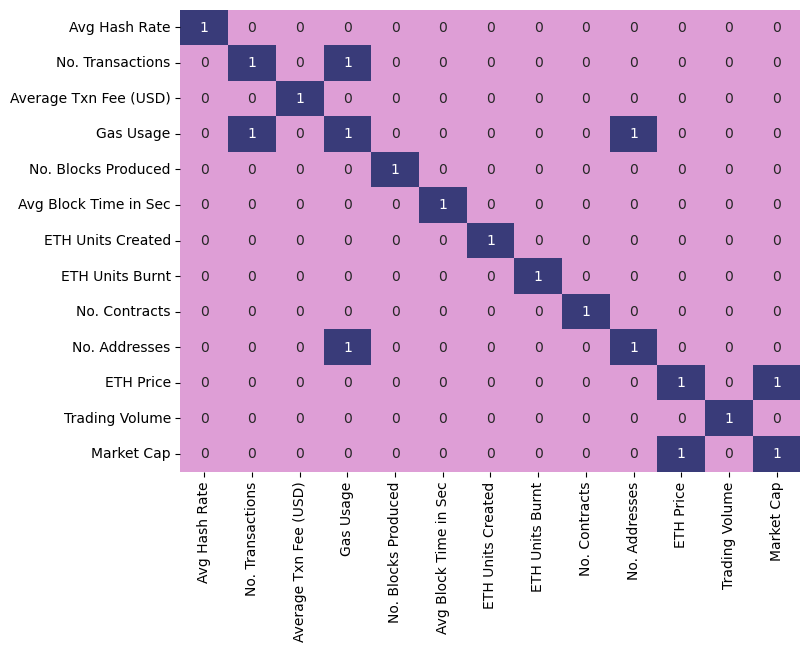

In [73]:
#Checking for linear correlation between features
plt.figure(figsize=(8, 6))
sb.heatmap(eth_final.corr() > 0.9, annot=True, cbar=False, cmap='tab20b_r')
plt.show()

__It turns out that the Gas Usage column is highly correlated with the Number of Transactions and with the Number of Addresses. I will try to replace it with data on the Average Gas Price and see whether the correlation remains. I will also remove the Market Capitalization indicator, since, of course, it is correlated with the Price.__

In [74]:
eth_gas_price = pd.read_csv("C:/Users/35989/Desktop/AI/Machine Learning/Final Project/export-AvgGasPrice.csv")
eth_gas_price = preprocessing(eth_gas_price)
eth_gas_price['Value (Wei)'] = eth_gas_price['Value (Wei)']/10**9
eth_gas_price = eth_gas_price.rename(columns={'Value (Wei)':'Gas Price in ETH'})

C:\Users\35989\AppData\Local\Temp\ipykernel_18772\2801788754.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, values in df.iteritems():


In [75]:
eth_final = eth_final.drop(columns=['Gas Usage', 'Market Cap'])
eth_final['Gas Price in ETH'] = eth_gas_price['Gas Price in ETH']

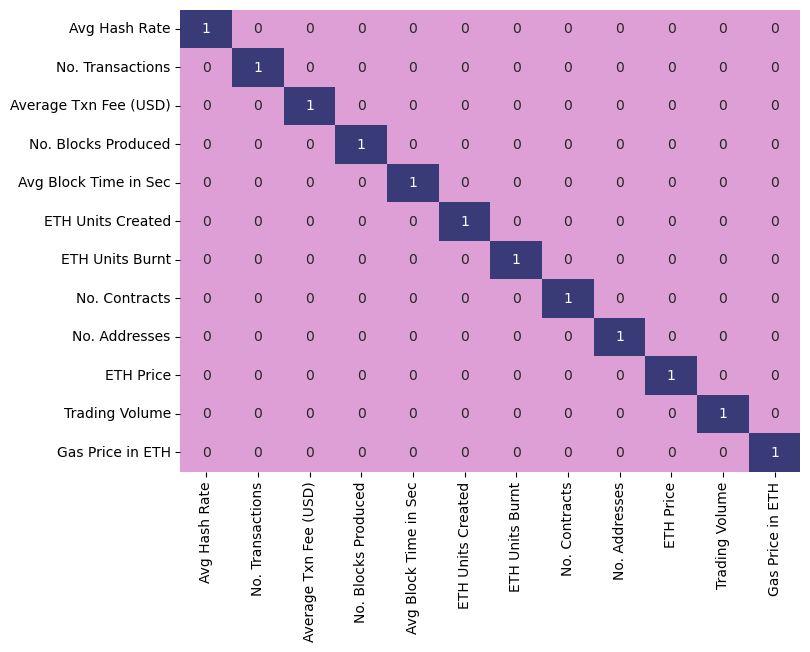

In [76]:
plt.figure(figsize=(8, 6))
sb.heatmap(eth_final.corr() > 0.9, annot=True, cbar=False, cmap='tab20b_r')
plt.show()

In [77]:
#Adding the Target Column
BUY = 1
SELL = 0
eth_final['Buy/Sell'] = np.where(eth_final['ETH Price'].shift(1) > eth_final['ETH Price'], 
                                BUY,
                                SELL)

In [78]:
label = eth_final['Buy/Sell']
features = eth_final.drop(columns='Buy/Sell')

In [79]:
features_train, features_test, label_train, label_test = train_test_split(features, label, random_state = 0)

In [80]:
features_train.shape, features_test.shape, label_train.shape, label_test.shape

((1995, 12), (666, 12), (1995,), (666,))

In [81]:
scaler = StandardScaler()

## Model I. SVM

In [82]:
pipe_svm = Pipeline(steps = [("scaler", scaler), ("classifier", SVC())])

In [83]:
param_grid = dict(classifier__kernel = ["rbf"],
                  classifier__gamma = [0.0001, 0.001, 0.01, 0.1], 
                  classifier__C = [0.001, 0.01, 0.1, 1, 10])

model_svm = GridSearchCV(pipe_svm, param_grid=param_grid, cv=10)
model_svm.fit(features_train, label_train)
predictions_svm_test = model_svm.best_estimator_.predict(features_test)
predictions_svm_train = model_svm.best_estimator_.predict(features_train)

In [84]:
model_svm.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(C=10, gamma=0.1))])

In [85]:
model_svm.score(features_test, label_test)

0.5180180180180181

In [86]:
model_svm.score(features_train, label_train)

0.5954887218045113

## Model II. Logistic Regression

In [87]:
pipe_logreg = Pipeline(steps = [("scaler", scaler), ("classifier", LogisticRegression())])

In [88]:
param_grid = dict(classifier__C = [0.01, 0.1, 1, 10, 100])  


model_logreg = GridSearchCV(pipe_logreg, param_grid = param_grid, cv=10)
model_logreg.fit(features_train, label_train)
predictions_logreg_test = model_logreg.best_estimator_.predict(features_test)
predictions_logreg_train = model_logreg.best_estimator_.predict(features_train)

In [89]:
model_logreg.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(C=1))])

In [90]:
model_logreg.score(features_test, label_test)

0.53003003003003

In [91]:
model_logreg.score(features_train, label_train)

0.5488721804511278

# Conclusion

As expected, the blockchain-related indicators and their changes over time do not bring enough useful information to predict ETH price. 

On the contrary, historical price data and time series features representing the price movements over time, despite coming with high correlation which usually harms the performance of some ML models, turned out to be much more effective in predicting the future price of the cryptocurrency.